# Imports

In [2]:
import numpy as np
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from adjustText import adjust_text

import unittest
import types
import os
from enum import Enum, auto

from ibm_watson import ApiException
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# Install:
# pip install numpy
# pip install -U scikit-learn
# pip install -U matplotlib
# pip install adjustText
# pip install --upgrade ibm-watson

# Classes

In [3]:
class SentimentAnalyzer:
    """Class for analyzing sentiments in a text."""
    
    def __init__(
        self,
        nlu_api_key = 'BRdFI4T27t2ge--crSB0jTuBakKQfro1S5uhTwx_wmj0',
        nlu_url = 'https://api.eu-gb.natural-language-understanding.watson.cloud.ibm.com/instances/c644c8ed-897a-4890-b692-e913c32b36bc',
        version = '2021-03-25'
    ):
        """Constructor for Sentiment Analyzer object.
        
        :param nlu_api_key (str, optional): API-key for IBM Watson Natural Language Understanding. Defaults to 'BRdFI4T27t2ge--crSB0jTuBakKQfro1S5uhTwx_wmj0'.
        :param nlu_url (str, optional): URL for IBM Watson Natural Language Understanding. Defaults to 'https://api.eu-gb.natural-language-understanding.watson.cloud.ibm.com/instances/c644c8ed-897a-4890-b692-e913c32b36bc'.
        :param version (str, optional): Version of IBM Watson Natural Language Understanding. Defaults to '2021-03-25'.
        """
        authenticator = IAMAuthenticator(nlu_api_key)
        self._service = NaturalLanguageUnderstandingV1(version=version, authenticator=authenticator)
        self._service.set_service_url(nlu_url)

    def analyze(self, analyzable, keywords = ['deep learning', 'singularity', 'logic', 'planning', 'autonomous']):
        """Analyze a text with IBM Watson Natural Language Understanding.
        
        :param analyzable (Analyzable): Analyzable object to analyze.
        :param keywords (list(str), optional): Keywords to target for sentiment analysis. Defaults to ['deep learning', 'singularity', 'logic', 'planning', 'autonomous'].
        :returns: List of Sentiment objects.
        :raises TypeError: If param types are incorrect.
        :raises ApiException: If API-key, URL or version params are invalid.
        """
        if not isinstance(analyzable, Analyzable):
            raise TypeError('Param analyzable should be Analyzable object')
        elif not isinstance(keywords, list):
            raise TypeError('Param keywords should be list of strings')
        else:
            for keyword in keywords:
                if not isinstance(keyword, str):
                    raise TypeError('Param keywords should be list of strings')
        
        try:
            # API call
            response = self._service.analyze(
                text = analyzable.get_text(),
                features = Features(sentiment = SentimentOptions(targets = keywords)),
            )
            results = response.result['sentiment']['targets']

            # Create Sentiment objects per keyword
            sentiments = []

            for keyword in keywords:
                is_present = False
                for result in results:
                    if result['text'] == keyword:
                        is_present = True
                        score = result['score']
                        label = SentimentTypes[result['label'].upper()]
                        sentiments.append(Sentiment(keyword, score, label))
                # If keyword is missing, create neutral Sentiment object
                if is_present == False:
                    sentiments.append(Sentiment(keyword, 0, SentimentTypes.NEUTRAL))
                
            return sentiments
        
        except ApiException: raise


class Sentiment:
    """Class to record sentiment toward a keyword."""
    
    def __init__(self, keyword, score, label):
        """Constructor for Sentiment object.
        
        :param keyword (str): Keyword to which the sentiment relates.
        :param score (float): Sentiment score toward the keyword.
        :param label (SentimentTypes): Label of the sentiment score toward the keyword.
        """
        self._keyword = keyword
        self._score = score
        self._label = label
    
    def get_keyword(self):
        return self._keyword
    
    def get_score(self):
        return self._score
    
    def get_label(self):
        return self._label


class SentimentTypes(Enum):
    """Enumeration of sentiment types: POSITIVE, NEUTRAL or NEGATIVE."""
    
    POSITIVE = auto()
    NEUTRAL = auto()
    NEGATIVE = auto()
    
    def get_color(self):
        """Return color related to sentiment type.
        
        :returns: String with color name.
        """
        if self == SentimentTypes.POSITIVE:
            return 'green'
        elif self == SentimentTypes.NEUTRAL:
            return 'orange'
        else:
            return 'red'


class Analyzable:
    """Class for analyzable object."""
    
    def __init__(self, text, id_ = None):
        """Constructor for Analyzable object.
        
        :param text (str): Text to be analyzed.
        :param id_ (any type): Id of the object. Defaults to None, which will induce id(self).
        :raises TypeError: If type of text param is incorrect.
        """
        if not isinstance(text, str):
            raise TypeError('Param should be string')
        self._text = text
        if id_ == None:
            self._id = id(self)
        else:
            self._id = id_
        self._sentiments = []
        
    def get_text(self):
        return self._text
    
    def get_id(self):
        return self._id
    
    def get_sentiments(self):
        return self._sentiments
    
    def get_sentiment_toward_keyword(self, keyword):
        """Return sentiment toward a given keyword.
        
        :param keyword (str): Keyword to which the sentiment relates.
        :returns: Sentiment object.
        :raises NameError: If there is no sentiment toward the given keyword.
        """
        if not isinstance(keyword, str):
            raise TypeError('Param should be string')
        is_present = False
        for sentiment in self._sentiments:
            if sentiment.get_keyword() == keyword:
                is_present = True
                return sentiment
        if is_present == False:
            raise NameError('No sentiment found toward given keyword')
    
    def set_sentiments(self, sentiments):
        self._sentiments = sentiments


class Person(Analyzable):
    """Class for analyzable Person."""
    
    def __init__(self, name, text):
        """Constructor for Person object.
        
        :param text (str): Text to be analyzed.
        :param name (str): Name of the person, will be used as id of the object.
        :raises TypeError: If type of name param is incorrect.
        """
        if not isinstance(name, str):
            raise TypeError('Param name should be string')
        super().__init__(text, name)
        
        
class AnalyzableObjects:
    """Class to list and group analyzable objects."""
    
    def __init__(self):
        self._analyzables = []
    
    def get_analyzables(self):
        return self._analyzables
    
    def append(self, obj):
        """Add analyzable object to analyzables list.
        
        :param obj (Analyzable): Object to be added to the analyzables list.
        :raises TypeError: If param type is incorrect.
        """
        if not isinstance(obj, Analyzable):
            raise TypeError('Param analyzable should be Analyzable object')
        self._analyzables.append(obj)
    
    def group_by_sentiment_type_toward_keyword(self, keyword):
        """Split analyzables in groups per sentiment type, based on sentiment toward a given keyword.
        
        :param keyword (str): Keyword to which the sentiment relates.
        :returns: Tuple of keyword and list of respectively positive, neutral and negative group lists.
        """
        positive_group = []
        neutral_group = []
        negative_group = []
        for obj in self._analyzables:
            sentiment_type = obj.get_sentiment_toward_keyword(keyword).get_label()
            if sentiment_type == SentimentTypes.POSITIVE:
                positive_group.append(obj)
            elif sentiment_type == SentimentTypes.NEUTRAL:
                neutral_group.append(obj)
            else:
                negative_group.append(obj)
        group = [positive_group, neutral_group, negative_group]
        return (keyword, group)
    
    def group_by_sentiment_score_toward_keyword(self, keyword, num_groups = 3):
        """Split analyzables in groups of equal size, based on sentiment score toward a given keyword.
        
        :param keyword (str): Keyword to which the sentiment relates.
        :param num_groups (int): Number of groups that should be created. Defaults to 3.
        :returns: Tuple of keyword and list of given number of group lists, divided by similar sentiment scores.
        :raises TypeError: If type of param num_groups is incorrect.
        """
        if not isinstance(num_groups, int):
            raise TypeError('Param num_groups should be integer')
        copied_group = self._analyzables.copy()
        copied_group.sort(key = lambda obj: obj.get_sentiment_toward_keyword(keyword).get_score())
        group = [arr.tolist() for arr in np.array_split(copied_group, num_groups)]
        return (keyword, group)
    
    def print_group(self, keyword_and_group):
        """Print group members per group with id, sentiment score and sentiment type toward a given keyword.
        
        :param keyword_and_group (tuple(str, list(list(Analyzable))): Tuple of keyword and list of group lists.
        :raises TypeError: If param type is incorrect.
        """
        if not isinstance(keyword_and_group, tuple) \
        or not isinstance(keyword_and_group[0], str) \
        or not isinstance(keyword_and_group[1], list):
            raise TypeError('Param keyword_and_group should be tuple of str and list')
        keyword = keyword_and_group[0]
        group = keyword_and_group[1]
        i = 1
        print(f'Groups are divided by their sentiment toward the keyword "{keyword}".')
        for lst in [lst for lst in group if len(lst) != 0]:
            print(f'Group {i}:')
            i += 1
            for member in lst:
                id_ = member.get_id()
                sentiment = member.get_sentiment_toward_keyword(keyword)
                sentiment_score = sentiment.get_score()
                sentiment_label = sentiment.get_label().name.lower()
                print(f'- {id_}: {sentiment_score} ({sentiment_label})')
    
    def create_dissimilarities_matrix(self, keyword):
        """Create dissimilarities matrix of group members' sentiment scores toward a given keyword.
        
        :param keyword (str): Keyword to which the sentiment relates.
        :returns: Tuple of keyword and 2D ndarray with sentiment score differences among group members.
        :raises ValueError: If self._analyzables is empty.
        """
        if len(self._analyzables) == 0:
            raise ValueError('The list of analyzable objects (self._analyzables) is empty. Add Analyzable objects with the append method.')
        length = len(self._analyzables)
        dissimilarities_matrix = np.empty([length, length])
        for x in range(length):
            for y in range(length):
                score_x = self._analyzables[x].get_sentiment_toward_keyword(keyword).get_score()
                score_y = self._analyzables[y].get_sentiment_toward_keyword(keyword).get_score()
                dissimilarities_matrix[x,y] = abs(score_x - score_y)
        return (keyword, dissimilarities_matrix)
    
    def print_scatterplot(self, keyword_and_dissimilarities_matrix):
        """Print scatterplot of dissimilarities matrix of group members' sentiment scores toward a given keyword.
        
        :param keyword_and_dissimilarities_matrix (tuple(str, ndarray)): Tuple of keyword and 2D ndarray of group members' sentiment scores toward a given keyword.
        :raises TypeError: If param type is incorrect.
        """
        if not isinstance(keyword_and_dissimilarities_matrix, tuple) \
        or not isinstance(keyword_and_dissimilarities_matrix[0], str) \
        or not isinstance(keyword_and_dissimilarities_matrix[1], np.ndarray):
            raise TypeError('Param keyword_and_dissimilarities_matrix should be tuple of str and ndarray')
        keyword = keyword_and_dissimilarities_matrix[0]
        dissimilarities_matrix = keyword_and_dissimilarities_matrix[1]
        
        # Create array with ids and colors of group members
        group_members = []
        for member in self._analyzables:
            id_ = member.get_id()
            sentiment_type = member.get_sentiment_toward_keyword(keyword).get_label()
            group_members.append((id_, sentiment_type.get_color()))
        
        # Create scatterplot
        mds = model = manifold.MDS(dissimilarity='precomputed')
        out = model.fit_transform(dissimilarities_matrix)
        plt.figure(figsize=(12,8), dpi= 100)
        plt.scatter(out[:, 0], out[:, 1], c = [member[1] for member in group_members])
        plt.axis('equal')
        plt.title(f'Sentiment toward "{keyword}"')
        plt.legend([Line2D([0], [0], linewidth = 0, marker = 'o', color = 'green'), 
                   Line2D([0], [0], linewidth = 0, marker = 'o', color = 'orange'),
                   Line2D([0], [0], linewidth = 0, marker = 'o', color = 'red')], 
                   ['Positive', 'Neutral', 'Negative'])
        
        # Place marker labels
        # Option 1: dynamically, improved label placement (slower)
        labels = [member[0] for member in group_members]
        texts = []
        for x, y, text in zip(out[:, 0], out[:, 1], labels):
            texts.append(plt.text(x, y, text))
        adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle="-|>", color='grey', alpha=0.5))
        ## Option 2: statically, overlapping labels (faster)
        # for i, id_ in enumerate([member[0] for member in group_members]):
        #     plt.annotate(id_, (out[i, 0], out[i, 1]))

# Program

Groups are divided by their sentiment toward the keyword "deep learning".
Group 1:
- Mola: -0.75483 (negative)
- Auri: 0 (neutral)
- Bast: 0 (neutral)
- Elodin: 0 (neutral)
- Geoffrey: 0 (neutral)
- Hemme: 0 (neutral)
- Iax: 0 (neutral)
Group 2:
- Jaxim: 0 (neutral)
- Kvothe: 0 (neutral)
- Lanre: 0 (neutral)
- Old Cob: 0.39416 (positive)
- Penthe: 0.4475 (positive)
- Simmon: 0.741465 (positive)
Group 3:
- Nina: 0.823679 (positive)
- Deoch: 0.847489 (positive)
- Rethe: 0.890236 (positive)
- Tempi: 0.91158 (positive)
- Felurian: 0.955538 (positive)
- Cinder: 0.974536 (positive)

Groups are divided by their sentiment toward the keyword "deep learning".
Group 1:
- Cinder: 0.974536 (positive)
- Deoch: 0.847489 (positive)
- Felurian: 0.955538 (positive)
- Nina: 0.823679 (positive)
- Old Cob: 0.39416 (positive)
- Penthe: 0.4475 (positive)
- Rethe: 0.890236 (positive)
- Simmon: 0.741465 (positive)
- Tempi: 0.91158 (positive)
Group 2:
- Auri: 0 (neutral)
- Bast: 0 (neutral)
- Elodin: 0 (neutral

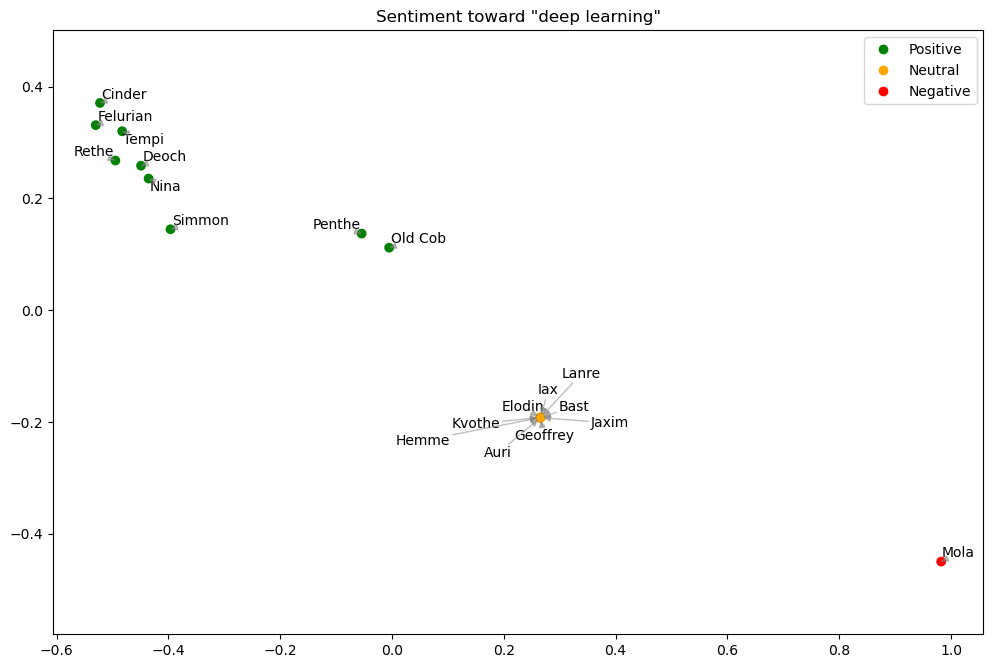

In [4]:
input = [
    ['Auri', "I think that AI can be very interesting, because computers think with more logic than humans. The decisions are based on the results that are processed with deep learning. There are also AI systems that develop themselves with their own planning. That way systems will evolve that can reason autonomous. In the end a singularity can be generated and that will be terrible for humanity. Humans will become slaves to machines as is demonstrated in many movies and books."],
    ['Bast', "I think that AI can be very interesting, because computers think with more logic than humans. The decisions are based on the results that are processed with deep learning. There are also AI systems that develop themselves with their own planning. That way systems will evolve that can reason autonomous. In the end a singularity can be generated and that will be terrible for humanity. Humans will become slaves to machines as is demonstrated in many movies and books."],
    ['Cinder', "Deep learning is already a blessing. We are quite far from Singularity. AI logic would probably work differently than human logic. Automatic planning and scheduling can solve more complex problems. Autonomous operations by vehicles and (virtual) robots driven by AI will be a significant part of our future."],
    ['Deoch', "Singularity, when computer intelligence will be beyond human brain capacity and still growing might be a bit scary but fortunately we can still pull out the plug ! I guess some day autonomous computers might create conceptual new computers themselves by means of deep learning and recursive self improvement. Logic thinking is a powerfull tool in biological behaviour and survival but essential in Python programming! If you are failing to plan, you're planning to fail."],
    ['Elodin', "Deep learning has moved from theory to practice in the field of artificial intelligence. A singularity as a doomsday scenario is not realistic at the current and near future state of technology. But military use of autonomous devices will become a problem if you look at history and use of technology. Both strategy and tactics are a matter of planning and logic, what is what Artificial Intelligence is good at."],
    ['Felurian', "Deep learning is an interesting way of doing machine learning. Singularity is both fascinating and frightening. If more systems were to become autonomous, our lives would become easier. Logic is the basis for all we have discovered. Planning is a difficult thing but important."],
    ['Geoffrey', "Does it rain? No it is deep learning. When AI reach singularity the weather will not be predicted but AI will autonomous be planning the weather so we people can talk about the weather when we have nothing to do. That’s logic."],
    ['Hemme', "Deep learning could be dangerous. If a machine learns autonomously, the logic can't be traced. There is a chance of singularity happening, although then I would expect it to have happened already. There are good uses for deep learning, e.g. planning."],
    ['Iax', "A singularity within deep learning supposes exponential growth of computer capacity. In nature exponential growth always stops itself so this goes against any logic. Autonomous learning does make sence and will grow according to planning."],
    ['Jaxim', "Deep learning is a form of machine learning through multi-layered neural networks. It will lead to singularity whereby superhuman intelligences will set different priorities than humanity. AI will no longer follow human logic. I don’t know exactly when AI is planning to become autonomous, but probably within some decades."],
    ['Kvothe', "Today the machines are learning deeply from the logic we provide them. The singularity will happend in a very near future and if machines become autonomous, we humans will have to change the planning of our future life."],
    ['Lanre', "The movie 'Terminator' predicted singularity of autonomous machines. A terrible perspective on our future. The machines used logic and deep learning (I guess) for the purpose of their own existence. They acted as humans, planning their own survival, but without the ethical boundaries. If we proceed with AI development, we need to do so with caution."],
    ['Mola', "The singularity has been depicted as the start of a dystopian future in many science fiction movies. Fully autonomous machines with flawed logic and poor planning seem to be a catalyst to arrive at such a future. Deep learning however seems to be a mostly harmless technique."],
    ['Nina', "Deep learning is a machine learning technique that teaches computers to do what humans  do.  I hope they don't achieve singularity. That would seriously challenge all logic. Even with proper planning this will lead to poor human performance. I only have one question. Will these autonomous machines make a decent cup of coffee?"],
    ['Old Cob', "Deep learning is an artificial intelligence (AI) function that imitates the workings of the human brain. Deep learning will never bring us to a hypothetical point in time at which technological growth becomes uncontrollable and irreversible, resulting in unforeseeable changes to human civilization. We call the aforementioned technological singularity. However, at the hypothetical point of technological singularity indeed no autonomous machines, nor any logic reasoning, and or planning, is required anymore."],
    ['Penthe', "In my humble opinion the singularity will not become a reality. When I watch my daughter, and I did this for many hours, how she discovers the world I realize how limited intelligent agents are. Even with techniques like deep learning we are not even close to how a toddler is able to learn.  Where the toddler will only need a bit of observation, a handful of examples and a few corrections, you will need to give the machine thousands of image to start being good at this game.  Although for example AI planning and logic are tools which have a lot of practical use I do not think we will develop a fully autonomous machine that will change the course of history quite soon."],
    ['Rethe', "Deep learning can benefit human life significantly. As of now it is hard to tell if singularity is good or bad. The logic and planning used by autonomous machines makes them excel in tasks humans can do just mediocre."],
    ['Simmon', "Of course Deep Learning is interesting from a technology perspective. The technology can tell us more about how our brain works, and give us detailed insights in ourselves. From a socilogical perspective deep learning might be challenging. Whwre automation had a major effect on the blue collar worker, deep learning might have a huge effect on the white collar worker. Are we ready for those effects? On top of that if we support a medical doctor in their diagnosis, based on deep learning, who will be leading, and who will be responsible in case of a misdiagnosis. Will that be the devloper who wrote the algoritm or will it be the doctor who missed. Challenges whihc are not so much in technology but in society, and we need to solve them, before we start to use the technology at large scale. Logic can be defined as the proof or validation behind any reason provided.  In the run for transparency in the use of artifcial intelligence, but also in the run for automation, show the logic is important. You need to show how you deduct towards a certain conclucsion or action. I sure hope we learn this in this course. Before Corona I had a large discussion with an architect from RDW about Autonomous cars. He liked the concept and really wanted to start pilots with it. And the technology is cool he said. But society is not ready, because a complete autonomous car has huge implications on the insurance, the road infrastructure etc. What are you going to do when an autonomous vehicle makes an accident. Who is responsible? The passenger, because the people in the car are not driving, it is the software. Is it the developer of the software, or is the supplier of the sensors? Is this car manufacturer? How do you solve this? And then how do you handle exceptions that you have not planned for. because in life there will be exceptions which is the key capability of a human. So I do think it is difficult to easily state what is going to happen. The technological singularity—also, simply, the singularity —is a hypothetical point in time at which technological growth becomes uncontrollable and irreversible, resulting in unforeseeable changes to human civilization. With the read of 'The Shallows' from N. Carr I would state that we already entered this inflection point. With the use of navigation systems I do experience myself that I am less able to navigate without the solution. What will it be for my kids. Also if we look at education, I learned fact and figures, important to get a proper understanding of history timelines. I do see with my kids, that they will look for details at the internet, and I do see it with myself during this course also. That changes learning, and approaches in life. And I do see in the practice of midwifery a change, people come with their Googled diagnosis, and have less respect for the professional opinion of the midwife. let alone the discussion on how we get news, and how this influences us. So I do see a huge change in society, and I think this is irreversible. Planning is the process of thinking about the activities required to achieve a desired goal. For tasks that are done repeatedly I think AI is  wonderful solution. And you could embrace several data sources to extend this."],
    ['Tempi', "Deep learning is an exciting and promising application of computing technology that can facilitate further automation. Enabling computers to become autonomous in tasks that previously required human intelligence will further increase productivity and increase prosperity. A key aspect is that computers are now able to move away from simple logic-based tasks and perform tasks that involve learning, planning, etcetera. Though this technology is promising, dystopian (or utopian) prospects of a techonolocigal singularity seem unfounded in the foreseeable future. Progress is still very much incremental, with machines being adapted to new tasks gradually and mostly under human supervision. Even a state-of-the-art deep learning algorithm such as Deep Mind requires extensive work to adapt to new tasks, and it is still headline news when it outperforms human experts."],
]

analyzer = SentimentAnalyzer()
analyzables = AnalyzableObjects()

# Create Person objects with sentiments and add them to the analyzables list
for arr in input:
    person = Person(arr[0], arr[1])
    sentiments = analyzer.analyze(person)
    person.set_sentiments(sentiments)
    analyzables.append(person)

keyword = 'deep learning'

# Divide analyzables in groups of equal size by sentiment score toward keyword
group_by_sentiment_score = analyzables.group_by_sentiment_score_toward_keyword(keyword)
analyzables.print_group(group_by_sentiment_score)
print('')

# Divide analyzables in groups per sentiment type toward keyword
group_by_sentiment_type = analyzables.group_by_sentiment_type_toward_keyword(keyword)
analyzables.print_group(group_by_sentiment_type)
print('')

# Print scatterplot of analyzables' sentiment toward keyword
dissimilarities_matrix = analyzables.create_dissimilarities_matrix(keyword)
analyzables.print_scatterplot(dissimilarities_matrix)

# Unittests

In [5]:
class TestSentimentAnalyzer(unittest.TestCase):
    """Unittest for class SentimentAnalyzer."""
    
    def setUp(self):
        self.analyzer = SentimentAnalyzer()
        self.analyzable = Analyzable('This is a test.')
    
    def test_sentiment_analyzer_analyze_invalid_analyzable_arg(self):
        with self.assertRaises(TypeError):
            self.analyzer.analyze('test')
        obj = types.SimpleNamespace()
        obj.text = 'This is a test.'
        with self.assertRaises(TypeError):
            self.analyzer.analyze(obj)
    
    def test_sentiment_analyzer_analyze_invalid_keywords_arg(self):
        with self.assertRaises(TypeError):
            self.analyzer.analyze(self.analyzable, 'test')
        with self.assertRaises(TypeError):
            self.analyzer.analyze(self.analyzable, [1, 2])


class TestSentimentTypes(unittest.TestCase):
    """Unittest for class SentimentTypes"""
    
    def test_sentiment_types_get_color_correct_result_type(self):
        color = SentimentTypes.POSITIVE.get_color()
        self.assertIsInstance(color, str)
    
    def test_sentiment_types_get_color_correct_result_values(self):
        self.assertEqual(SentimentTypes.POSITIVE.get_color(),'green')
        self.assertEqual(SentimentTypes.NEUTRAL.get_color(), 'orange')
        self.assertEqual(SentimentTypes.NEGATIVE.get_color(), 'red')
        
            
class TestAnalyzable(unittest.TestCase):
    """Unittest for class Analyzable."""
    
    def setUp(self):
        self.analyzable = Analyzable('This is a test.')
        self.sentiments = [Sentiment('test', 0.6, SentimentTypes.POSITIVE), 
                           Sentiment('deep learning', -0.2, SentimentTypes.NEGATIVE), 
                           Sentiment('university', 0, SentimentTypes.NEUTRAL)]
        self.analyzable.set_sentiments(self.sentiments)
    
    def test_analyzable_invalid_text_arg(self):
        with self.assertRaises(TypeError):
            Analyzable(1)
        with self.assertRaises(TypeError):
            Analyzable(['test 1', 'test 2'])
    
    def test_analyzable_get_sentiment_toward_keyword_invalid_keyword_arg(self):
        with self.assertRaises(TypeError):
            self.analyzable.get_sentiment_toward_keyword(1)
        with self.assertRaises(TypeError):
            self.analyzable.get_sentiment_toward_keyword(['test 1', 'test 2'])
    
    def test_analyzable_get_sentiment_toward_keyword_no_sentiment_found(self):
        with self.assertRaises(NameError):
            self.analyzable.get_sentiment_toward_keyword('test 1')
    
    def test_analyzable_get_sentiment_toward_keyword_correct_result_type(self):
        sentiment = self.analyzable.get_sentiment_toward_keyword('test')
        self.assertIsInstance(sentiment, Sentiment)
    
    def test_analyzable_get_sentiment_toward_keyword_correct_result_values(self):
        sentiment = self.analyzable.get_sentiment_toward_keyword('test')
        self.assertEqual(sentiment, self.sentiments[0])
        sentiment = self.analyzable.get_sentiment_toward_keyword('deep learning')
        self.assertEqual(sentiment, self.sentiments[1])
        sentiment = self.analyzable.get_sentiment_toward_keyword('university')
        self.assertEqual(sentiment, self.sentiments[2])
            
            
class TestPerson(unittest.TestCase):
    """Unittest for class Person."""
    
    def setUp(self):
        self.person = Person('Name', 'This is a test.')
    
    def test_person_invalid_name_arg(self):
        text = 'This is a test.'
        with self.assertRaises(TypeError):
            Person(True, text)
        with self.assertRaises(TypeError):
            Person(1, text)
        with self.assertRaises(TypeError):
            Person(['Name 1', 'Name 2'], text)
    
    def test_person_correct_inheritance_of_analyzable(self):
        self.assertIsInstance(self.person, Analyzable)
        
    def test_person_correct_transfer_of_text_arg_to_analyzable_object(self):
        self.assertEqual(self.person.get_text(), 'This is a test.')
    
    def test_person_correct_transfer_of_name_arg_to_analyzable_object(self):
        self.assertEqual(self.person.get_id(), 'Name')

        
class TestAnalyzableObjects(unittest.TestCase):
    """Unittest for class AnalyzableObjects."""
    
    def setUp(self):
        self.person1 = Person('Name 1', 'This is a test.')
        sentiments1 = [Sentiment('test', 0.6, SentimentTypes.POSITIVE)]
        self.person1.set_sentiments(sentiments1)
        self.person2 = Person('Name 2', 'This is another unit test.')
        sentiments2 = [Sentiment('test', -0.4, SentimentTypes.NEGATIVE)]
        self.person2.set_sentiments(sentiments2)
        self.analyzables = AnalyzableObjects()
        self.keyword = 'test'
            
    def test_analyzable_objects_append_invalid_obj_arg(self):
        with self.assertRaises(TypeError):
            self.analyzables.append('Test')
        obj = types.SimpleNamespace()
        obj.text = 'This is a test.'
        with self.assertRaises(TypeError):
            self.analyzables.append(obj)

    def test_analyzable_objects_append_correct_result_values(self):
        self.analyzables.append(self.person1)
        self.assertEqual(len(self.analyzables.get_analyzables()), 1)
        self.analyzables.append(self.person2)
        self.assertEqual(len(self.analyzables.get_analyzables()), 2)
        self.assertEqual(self.analyzables.get_analyzables()[0], self.person1)
        self.assertEqual(self.analyzables.get_analyzables()[1], self.person2)
        
    def test_analyzable_objects_group_by_sentiment_type_toward_keyword_correct_result_type(self):
        self.analyzables.append(self.person1)
        result = self.analyzables.group_by_sentiment_type_toward_keyword(self.keyword)
        self.assertIsInstance(result, tuple)
        self.assertIsInstance(result[0], str)
        self.assertIsInstance(result[1], list)
        for lst in result[1]:
            for obj in lst:
                self.assertIsInstance(obj, Analyzable)
                
    def test_analyzable_objects_group_by_sentiment_type_toward_keyword_correct_result_values(self):
        self.analyzables.append(self.person1)
        result = self.analyzables.group_by_sentiment_type_toward_keyword(self.keyword)
        for lst in result[1]:
            if len(lst) > 0:
                lst_set = set([obj.get_sentiment_toward_keyword(self.keyword).get_label() for obj in lst])
                self.assertEqual(len(lst_set), 1)
        self.assertTrue(self.person1 in result[1][0])
    
    def test_analyzable_objects_group_by_sentiment_score_toward_keyword_invalid_num_groups_arg(self):
        self.analyzables.append(self.person1)
        with self.assertRaises(TypeError):
            self.analyzables.group_by_sentiment_score_toward_keyword(self.keyword, 3.5)
        with self.assertRaises(TypeError):
            self.analyzables.group_by_sentiment_score_toward_keyword(self.keyword, 'test')
        with self.assertRaises(TypeError):
            self.analyzables.group_by_sentiment_score_toward_keyword(self.keyword, [1, 2])

    def test_analyzable_objects_group_by_sentiment_score_toward_keyword_correct_result_type(self):
        self.analyzables.append(self.person1)
        result = self.analyzables.group_by_sentiment_score_toward_keyword(self.keyword)
        self.assertIsInstance(result, tuple)
        self.assertIsInstance(result[0], str)
        self.assertIsInstance(result[1], list)
        for lst in result[1]:
            for obj in lst:
                self.assertIsInstance(obj, Analyzable)
    
    def test_analyzable_objects_group_by_sentiment_score_toward_keyword_correct_result_values(self):
        num_groups = 3
        self.analyzables.append(self.person1)
        result = self.analyzables.group_by_sentiment_score_toward_keyword(self.keyword, num_groups)
        self.assertEqual(len(result[1]), num_groups)
        self.assertTrue(self.person1 in result[1][0])
    
    def test_analyzable_objects_print_group_invalid_keyword_and_group_arg_no_tuple(self):
        self.analyzables.append(self.person1)
        group = self.analyzables.group_by_sentiment_type_toward_keyword(self.keyword)
        with self.assertRaises(TypeError):
            self.analyzables.print_group(self.keyword)
        with self.assertRaises(TypeError):
            self.analyzables.print_group([self.keyword, group])
    
    def test_analyzable_objects_print_group_invalid_keyword_and_group_arg_tuple_without_str(self):
        self.analyzables.append(self.person1)
        group = self.analyzables.group_by_sentiment_type_toward_keyword(self.keyword)
        with self.assertRaises(TypeError):
            self.analyzables.print_group((1, group))
        with self.assertRaises(TypeError):
            self.analyzables.print_group(([self.keyword], group))
        
    def test_analyzable_objects_print_group_invalid_keyword_and_group_arg_tuple_without_list(self):
        self.analyzables.append(self.person1)
        with self.assertRaises(TypeError):
            self.analyzables.print_group((self.keyword, 'Object'))
        with self.assertRaises(TypeError):
            self.analyzables.print_group((self.keyword, self.person1))
    
    def test_analyzable_objects_create_dissimilarities_matrix_empty_analyzables_list(self):
        with self.assertRaises(ValueError):
            self.analyzables.create_dissimilarities_matrix(self.keyword)[1]
    
    def test_analyzable_objects_create_dissimilarities_matrix_correct_result_type(self):
        self.analyzables.append(self.person1)
        self.analyzables.append(self.person2)
        dissimilarities_matrix = self.analyzables.create_dissimilarities_matrix(self.keyword)[1]
        self.assertIsInstance(dissimilarities_matrix, np.ndarray)
        for x in range(len(dissimilarities_matrix)):
            for y in range(len(dissimilarities_matrix)):
                self.assertIsInstance(dissimilarities_matrix[x,y], float)
    
    def test_analyzable_objects_create_dissimilarities_matrix_correct_result_values(self):
        self.analyzables.append(self.person1)
        self.analyzables.append(self.person2)
        dissimilarities_matrix = self.analyzables.create_dissimilarities_matrix(self.keyword)[1]
        self.assertEqual(dissimilarities_matrix.shape, (2,2))
        self.assertEqual(dissimilarities_matrix[0,0], 0.0)
        self.assertEqual(dissimilarities_matrix[1,1], 0.0)
        self.assertEqual(dissimilarities_matrix[0,1], 1.0)
        self.assertEqual(dissimilarities_matrix[1,0], 1.0)
    
    def test_analyzable_objects_print_scatterplot_invalid_keyword_and_dissimilarities_matrix_arg_no_tuple(self):
        self.analyzables.append(self.person1)
        dissimilarities_matrix = self.analyzables.create_dissimilarities_matrix(self.keyword)
        with self.assertRaises(TypeError):
            self.analyzables.print_scatterplot(self.keyword)
        with self.assertRaises(TypeError):
            self.analyzables.print_scatterplot([self.keyword, dissimilarities_matrix])
            
    def test_analyzable_objects_print_scatterplot_invalid_keyword_and_dissimilarities_matrix_tuple_without_str(self):
        self.analyzables.append(self.person1)
        dissimilarities_matrix = self.analyzables.create_dissimilarities_matrix(self.keyword)
        with self.assertRaises(TypeError):
            self.analyzables.print_scatterplot((1, dissimilarities_matrix))
        with self.assertRaises(TypeError):
            self.analyzables.print_scatterplot(([self.keyword], dissimilarities_matrix))
    
    def test_analyzable_objects_print_scatterplot_invalid_keyword_and_dissimilarities_matrix_tuple_without_ndarray(self):
        self.analyzables.append(self.person1)
        with self.assertRaises(TypeError):
            self.analyzables.print_scatterplot((self.keyword, 'Matrix'))
        with self.assertRaises(TypeError):
            self.analyzables.print_scatterplot((self.keyword, 1))
        with self.assertRaises(TypeError):
            self.analyzables.print_scatterplot((self.keyword, [1, 2]))

            
unittest.main(argv=[''], verbosity=2, exit=False)

test_analyzable_get_sentiment_toward_keyword_correct_result_type (__main__.TestAnalyzable) ... ok
test_analyzable_get_sentiment_toward_keyword_correct_result_values (__main__.TestAnalyzable) ... ok
test_analyzable_get_sentiment_toward_keyword_invalid_keyword_arg (__main__.TestAnalyzable) ... ok
test_analyzable_get_sentiment_toward_keyword_no_sentiment_found (__main__.TestAnalyzable) ... ok
test_analyzable_invalid_text_arg (__main__.TestAnalyzable) ... ok
test_analyzable_objects_append_correct_result_values (__main__.TestAnalyzableObjects) ... ok
test_analyzable_objects_append_invalid_obj_arg (__main__.TestAnalyzableObjects) ... ok
test_analyzable_objects_create_dissimilarities_matrix_correct_result_type (__main__.TestAnalyzableObjects) ... ok
test_analyzable_objects_create_dissimilarities_matrix_correct_result_values (__main__.TestAnalyzableObjects) ... ok
test_analyzable_objects_create_dissimilarities_matrix_empty_analyzables_list (__main__.TestAnalyzableObjects) ... ok
test_analyzabl